<a href="https://colab.research.google.com/github/alexaugur/Collab/blob/main/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
k = 8                       # number of information bits
N = 16                      # code length
train_SNR_Eb = 1            # training-Eb/No

nb_epoch = 2**16            # number of learning epochs
code = 'polar'              # type of code ('random' or 'polar')
design = [128, 64, 32]      # each list entry defines the number of nodes in a layer
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
optimizer = 'adam'
loss = 'mse'                # or 'binary_crossentropy'

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

define nn model:


In [84]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma) #std=sigma added last two params
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))

def return_output_shape(input_shape):
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):
    return 2*x/np.float32(sigma**2)


def errors(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')
    return K.sum(K.cast(K.not_equal(y_true, y_pred), 'float32' ))




In [85]:

# function to define the decoder and model to train
#param llr - bool whether model uses llr before net
#param train_sigma - the std of the training noise
def create_decoder_model(llr, train_sigma):


  modulator_layers = [Lambda(modulateBPSK,
                          input_shape=(N,), output_shape=return_output_shape, name="modulator")]
  modulator = compose_model(modulator_layers)
  modulator.compile(optimizer=optimizer, loss=loss)

  # Define noise
  noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma},
                       input_shape=(N,), output_shape=return_output_shape, name="noise")]
  noise = compose_model(noise_layers) #creates a keras sequential model with the layers passed as params
  noise.compile(optimizer=optimizer, loss=loss)

  # Define LLR
  llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma},
                     input_shape=(N,), output_shape=return_output_shape, name="LLR")]
  llr = compose_model(llr_layers)
  llr.compile(optimizer=optimizer, loss=loss)



  # Define decoder
  decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
  for i in range(1,len(design)):
    decoder_layers.append(Dense(design[i], activation='relu'))
  decoder_layers.append(Dense(k, activation='sigmoid'))
  decoder = compose_model(decoder_layers)
  decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])

  # Define model
  if LLR:
    model_layers = modulator_layers + noise_layers + llr_layers + decoder_layers
  else:
    model_layers = modulator_layers + noise_layers + decoder_layers

  model = compose_model(model_layers)
  model.compile(optimizer=optimizer, loss=loss, metrics=[ber])

  return decoder, model



data generation:


In [86]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)

    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out

    return integer

def polar_design_awgn(N, k, design_snr_dB):

    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel

    # sort into increasing order
    idx = np.argsort(z0)

    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))

    A = np.zeros(N, dtype=bool)
    A[idx] = True

    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [87]:
#function to create the test and train datasets for given code and datalengths
#param code for type of code (polar of random)
#returns test and train sets of data
def generate_data(k, N, code):
  # Create all possible information words
  d = np.zeros((2**k,k),dtype=bool)
  for i in range(1,2**k):
    d[i]= inc_bool(d[i-1])

  # Create sets of all possible codewords (codebook)
  if code == 'polar':

    A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations
    x = np.zeros((2**k, N),dtype=bool)
    u = np.zeros((2**k, N),dtype=bool)
    u[:,A] = d

    for i in range(0,2**k):
        x[i] = polar_transform_iter(u[i])

  elif code == 'random':

    np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
    x = np.random.randint(0,2,size=(2**k,N), dtype=bool)

  return x, d

train neural net

In [88]:
decoder, model = create_decoder_model(LLR, train_sigma)
x, d = generate_data(k, N, code)

#prints out the summary of the model
model.summary()

#noise and modulator is built into model so it generates different noise for ever epoch
history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 modulator (Lambda)          (None, 16)                0         
                                                                 
 noise (Lambda)              (None, 16)                0         
                                                                 
 dense_80 (Dense)            (None, 128)               2176      
                                                                 
 dense_81 (Dense)            (None, 64)                8256      
                                                                 
 dense_82 (Dense)            (None, 32)                2080      
                                                                 
 dense_83 (Dense)            (None, 8)                 264       
                                                                 
Total params: 12,776
Trainable params: 12,776
Non-tr

test neural net

In [89]:
#evaluate the effectiveness on the model for a range of different sigmas
def evaluate_model(decoder, LLR, code, test_batch, num_words, sigmas):

  nb_errors = np.zeros(len(sigmas),dtype=int)
  nb_bits = np.zeros(len(sigmas),dtype=int)

  for i in range(0,int(len(sigmas))):

      for ii in range(0,np.round(num_words/test_batch).astype(int)):

          # Source
          np.random.seed(0)
          d_test = np.random.randint(0,2,size=(test_batch,k))

          # Encoder
          if code == 'polar':
              x_test = np.zeros((test_batch, N),dtype=bool)
              u_test = np.zeros((test_batch, N),dtype=bool)
              A = polar_design_awgn(N, k, design_snr_dB=0)
              u_test[:,A] = d_test

              for iii in range(0,test_batch):
                  x_test[iii] = polar_transform_iter(u_test[iii])

          elif code == 'random':
              x_test = np.zeros((test_batch, N),dtype=bool)
              for iii in range(0,test_batch):
                  x_test[iii] = x[bin2int(d_test[iii])]

          # Modulator (BPSK)
          s_test = -2*x_test + 1

          # Channel (AWGN)
          y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

          if LLR:
              y_test = 2*y_test/(sigmas[i]**2)

          # Decoder
          nb_errors[i] += (decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0))[1]
          nb_bits[i] += d_test.size
  return nb_errors, nb_bits

In [90]:
test_batch = 1000
num_words = 100000      # multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20
SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

evaluate model for polar codes

In [91]:

nb_errors, nb_bits = evaluate_model(decoder, LLR, code, test_batch, num_words, sigmas)

load map data

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]




```
# This is formatted as code
```

Plot Bit-Error_Rate

(epcohs = 2^16, trained on channel w gaussian noise w an eb/no of 1)


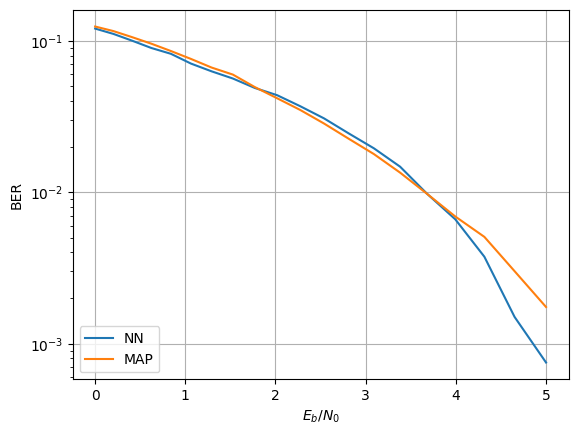

In [93]:
legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits)
legend.append('NN')

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')
plt.grid(True)
plt.show()

plot BER for random codes

In [94]:
code = 'random'
decoder, model = create_decoder_model(LLR, train_sigma)
x, d = generate_data(k, N, code)
history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)

nb_errors, nb_bits = evaluate_model(decoder, LLR, code, test_batch, num_words, sigmas)


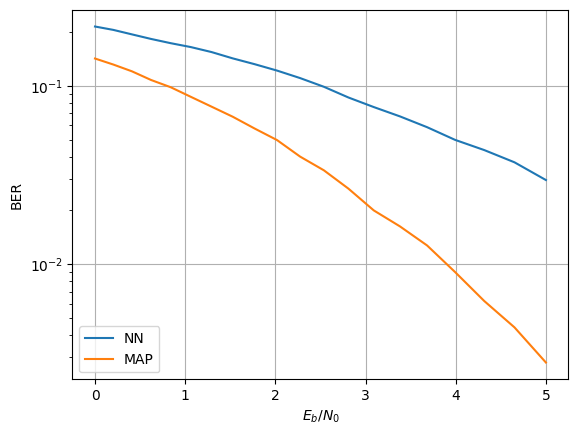

In [95]:
result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]

legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits)
legend.append('NN')

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')
plt.grid(True)
plt.show()

BER vs Noise for different epochs (polar code)

In [96]:
code = 'polar'
epochs = [2**10, 2**12, 2**14, 2**16, 2**18]


#2d lists  - each list is a different epoch length and the data within the list corresponds to different SNRs
errors_ep = []
bits_ep = []


#train and evaluate the model for each amount of epochs
for e in epochs:
  decoder, model = create_decoder_model(LLR, train_sigma)
  x, d = generate_data(k, N, code)
  history = model.fit(x, d, batch_size=batch_size, epochs=e, verbose=0, shuffle=True)

  sig_errors = []
  sig_bits = []

  sig_errors, sig_bits = evaluate_model(decoder, LLR, code, test_batch, num_words, sigmas)

  errors_ep.append(sig_errors)
  bits_ep.append(sig_bits)

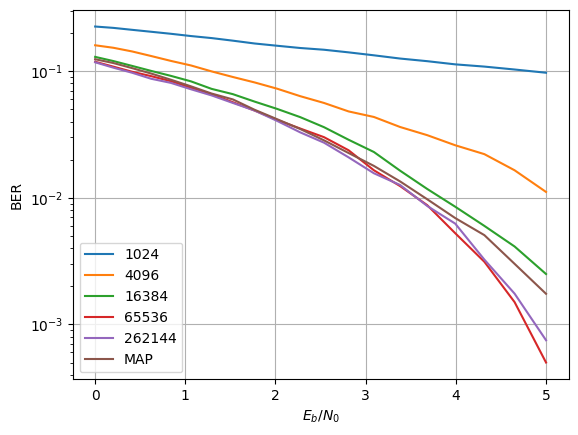

In [118]:
legend = []
for i in range (len(epochs)):
  plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), errors_ep[i]/bits_ep[i])
  #legend.append('$M_e = 2^{0}$'.format(epochs[i]))
  legend.append(str(epochs[i]))


result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]
plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')

plt.grid(True)
plt.show()


BER vs Noise for different epochs (random code)

In [119]:
code = 'random'
epochs = [2**10, 2**12, 2**14, 2**16, 2**18]


#2d lists  - each list is a different epoch length and the data within the list corresponds to different SNRs
errors_ep = []
bits_ep = []


#train and evaluate the model for each amount of epochs
for e in epochs:
  decoder, model = create_decoder_model(LLR, train_sigma)
  x, d = generate_data(k, N, code)
  history = model.fit(x, d, batch_size=batch_size, epochs=e, verbose=0, shuffle=True)

  sig_errors = []
  sig_bits = []

  sig_errors, sig_bits = evaluate_model(decoder, LLR, code, test_batch, num_words, sigmas)

  errors_ep.append(sig_errors)
  bits_ep.append(sig_bits)

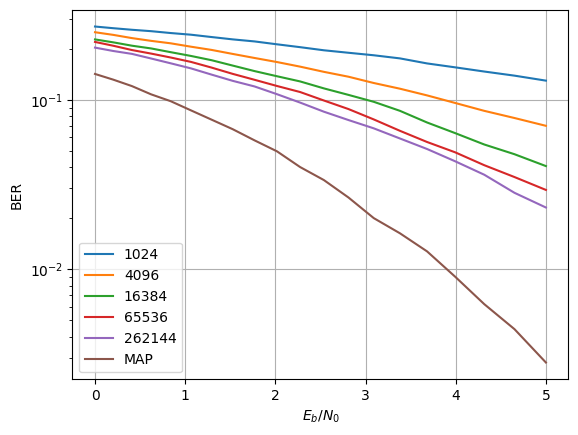

In [124]:
legend = []
for i in range(len(epochs)):
  plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), errors_ep[i]/bits_ep[i])
  legend.append(str(epochs[i]))


result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]
plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')

plt.grid(True)
plt.show()

In [120]:

#function to compute the normal validation error
def nve(code, N, k, errors, bits, sigmas):
  result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
  sigmas_map = result_map[:,0]
  nb_bits_map = result_map[:,1]
  nb_errors_map = result_map[:,2]

  nve = 0
  #assuming that MAP data is for same range and step of sigmas
  for i in len(sigmas):
    nve += (errors[i]/bits[i] )/ (nb_errors_map[i] / nb_bits_map [i])
  nve = nve / len(sigmas)
  return nve


trained on different snrs

In [ ]:
code = 'polar'
train_sigmas = np.linspace(-2, 6, 9) #
#reminder that the sigmas list is still between 0 and 5 dB

nves = []

errors_ts = []
bits_ts = []

for sigma in train_sigmas:
  decoder, model = create_decoder_model(LLR, sigma)
  x, d = generate_data(k, N, code)
  history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)

  sig_errors = []
  sig_bits = []

  sig_errors, sig_bits = evaluate_model(decoder, LLR, code, test_batch, num_words, sigmas)

  errors_ts.append(sig_errors)
  bits_ts.append(sig_bits)
  nve = nve(code, N, k, sig_errors, sig_bits)
  nve.append()



In [ ]:
legend = []
for i in len(train_sigmas):
  plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), errors_ts[i]/bits_ts[i])
  legend.append(str(train_sigmas[i]))


result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=', ')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]
plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')

plt.grid(True)
plt.show()

In [ ]:
plt.plot(10*np.log10(1/(2*train_sigmas**2)) - 10*np.log10(k/N), nves)
plt.xlabel('Training $E_b/N_0$')
plt.ylabel('NVE')

plt.grid(True)
plt.show()



